## Gaussian separable models with vanishing point

### Imports

In [1]:
#!/usr/bin/env python3

from functools import wraps
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randn, rand
import numdifftools as nd
import picos as pc
from scipy.integrate import solve_ivp
from scipy.io import loadmat
import time
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

plt.style.use("default")

### Computation time

In [2]:
def runtime(func):
    @wraps(func)
    def runtime_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print("\n", f'Function {func.__name__} took {total_time:.4f} seconds')
        return result
    return runtime_wrapper

### Read data

In [3]:
name_of_dataset = 'Angle'    # To run Angle-shape
#name_of_dataset = 'Sshape'  # To run S-shape

# Unpack the trajectories and place into x and y used in learning step
dataset = loadmat("Dataset/" + name_of_dataset + '.mat')
num_of_demos = dataset['demos'].shape[1]
size_of_state = dataset['demos'][0, 0][0,0][0].shape[0]
dim_of_function = size_of_state 

#### Mean of training demonstrations

In [4]:
num_of_train_datasets = 4
num_of_points = len(dataset['demos'][0,0][0,0][0][0])

pos_cell_1 = np.zeros((num_of_points, num_of_train_datasets))
pos_cell_2 = np.zeros((num_of_points, num_of_train_datasets))
vel_cell_1 = np.zeros((num_of_points, num_of_train_datasets))
vel_cell_2 = np.zeros((num_of_points, num_of_train_datasets))

# Concatenating the dataseries of position and velocities
for i in range(0, num_of_train_datasets):
    demo_struct = dataset['demos'][0,i][0,0]

    position_dataseries = dataset['demos'][0,i][0,0][0]
    velocity_dataseries = dataset['demos'][0,i][0,0][2]

    pos_cell_1[:, i] = position_dataseries[0]
    pos_cell_2[:, i] = position_dataseries[1]
    vel_cell_1[:, i] = velocity_dataseries[0]
    vel_cell_2[:, i] = velocity_dataseries[1]

x_train_1 = pos_cell_1.mean(axis=1)
x_train_2 = pos_cell_2.mean(axis=1)
y_train_1 = vel_cell_1.mean(axis=1)
y_train_2 = vel_cell_2.mean(axis=1)

# Defines the position and velocity measurements
x_train = np.array([x_train_1, x_train_2])
y_train = np.array([y_train_1, y_train_2])

# Get time info for simulating the learnt system later
time_step = dataset['dt'][0,0]

len_of_dataseries = dataset['demos'][0, 0][0,0][0].shape[1] 

concatenate = np.concatenate((np.array([[0]]), time_step * np.ones((1, len_of_dataseries - 1))),axis=1)
time_series = np.cumsum(concatenate)
num_of_timesteps = len_of_dataseries
num_of_test_datasets = num_of_demos - num_of_train_datasets

# Intial starting point for the simulated trajectory using learnt model
init_condition = x_train[:, 0]

timespan = np.array([time_series[0],time_series[-1]])
t_series = np.linspace(time_series[0],time_series[-1], 1000)

#### Plot training trajectory

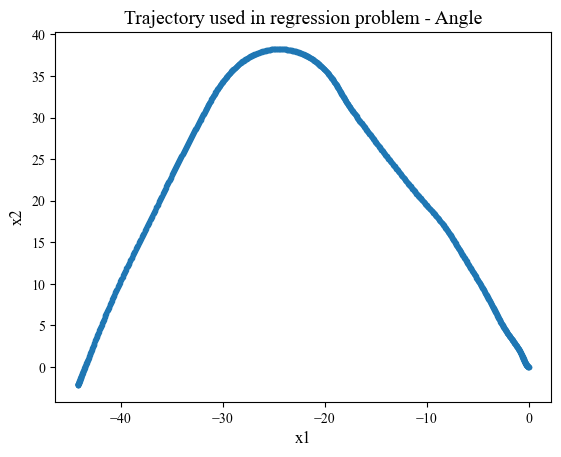

In [5]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": "Times New Roman",
})

fig_dataset = plt.figure(1)
plt.title('Trajectory used in regression problem - ' + name_of_dataset, fontsize=14)
plt.plot(x_train[0,:], x_train[1,:], '.')
plt.xlabel('x1', fontsize =12)
plt.ylabel('x2', fontsize=12)
fig_dataset.show()
axes = plt.gca() # Get current axes from the last plot

#### Define vector-field and axis

In [6]:
# Get lower and upper bound for plotting from dataset figure
lower_bound_x1 = axes.get_xlim()[0]
upper_bound_x1 = axes.get_xlim()[1]
lower_bound_x2 = axes.get_ylim()[0]
upper_bound_x2 = axes.get_ylim()[1]

num_of_points_for_plot = 25

x1 = np.linspace(lower_bound_x1-5, upper_bound_x1, num_of_points_for_plot)
x2 = np.linspace(lower_bound_x2, upper_bound_x2+4, num_of_points_for_plot)

# Base point or starting point for each vector of the vector field
[X1, X2] = np.meshgrid(x1, x2)

t = 0

### Regression problems with vanishing point and Gaussian separable feature map

#### Functions

In [7]:
def psi(x, w, b):
    return np.sqrt(2) * np.cos(w.T@x + b)

def psi_vector(x, w, b, d):
    psi_vector = np.zeros(d)
    for i in range(d):
        x = x.reshape((-1,))
        psi_vector[i] = psi(x, w[:, i], b[:,i])
    return np.array(psi_vector)

def capital_psi(x, w, b, d, dim):
    psi = psi_vector(x, w, b, d)
    return np.kron(psi, np.eye(dim))

def phi_function(x, w, b, N, d, dim):
    phi = np.zeros((dim*N, dim*d))
    psi = capital_psi(x, w, b, d, dim)
    phi[dim*0] = psi[0]
    phi[dim*0+1] = psi[1]
    return phi

def capital_psi_z_function(x, w, b, d, dim, L):
    psi = capital_psi(x, w, b, d, dim)
    return L.T @ psi.T

def capital_phi_z_function(x, w, b, N, d, dim, L):
    phi = np.zeros((dim*N, dim*d))
    for i in range(N):
        psi = capital_psi_z_function(x[:,i], w, b, d, dim, L)
        phi[dim*i] = psi.T[0]
        phi[dim*i+1] = psi.T[1]
    return phi

def psi_jacobi(x, w, b, d, dim, L):
    psi_vector = np.zeros(d)
    for i in range(d):
        psi_vector[i] = np.cos(w[:, i].T@x + b[:, i])
    psi = np.sqrt(2/d) * np.kron(psi_vector, np.eye(dim))
    psi_L = L.T @ psi.T
    return psi_L.T

#### Variables

In [8]:
sigma = 10
lambda_ = 0.1
num_of_constraint_points = 250
num_of_samples = 100
mu = 0.0

if name_of_dataset == 'Sshape':
    num_of_samples = 200

# Generate parameters for feature map
#w = randn(size_of_state, num_of_samples)/sigma
#b = rand(1,num_of_samples)*2*np.pi

# Load the saved parameters for feature map
w = np.load('RFF_parameters/w_'+name_of_dataset+'_vanish.npy')
b = np.load('RFF_parameters/b_'+name_of_dataset+'_vanish.npy')

#### Finding L

In [9]:
x_vanish = x_train[:,-1]
num_of_vanish_points = np.size(x_vanish[0])

capital_phi_z = phi_function(x_vanish, w, b, num_of_vanish_points, num_of_samples, dim_of_function)
capital_phi_z = capital_phi_z.T
P_Psi = capital_phi_z @ np.linalg.inv(capital_phi_z.T @ capital_phi_z)@capital_phi_z.T
P_Psi = np.eye(P_Psi[0].size) - P_Psi

# Ensure P is a Hermitian positive-definite matrix given numerical noise
P_Psi = (P_Psi + P_Psi.T) / 2 + (np.eye(P_Psi[0].size)*1e-12)

L_ = np.linalg.cholesky(P_Psi)

### Model with vanishing point

#### Alpha with vanishing point

In [10]:
@runtime
def alpha_approx_z(x, y, w, b, dim, d, lam, N, L):
    phi_ = capital_phi_z_function(x, w, b, N, d, dim, L)
    alpha_inv_part = np.linalg.inv(phi_.T @ phi_ + lam*np.eye(dim*d))
    y_reshaped = np.array(np.ravel([y[0], y[1]], 'F'))
    alpha = alpha_inv_part @ (phi_.T @ y_reshaped)
    return alpha

#### Solve regression problem

In [11]:
alpha_z = alpha_approx_z(x_train, y_train, w, b, dim_of_function, num_of_samples, lambda_, num_of_points, L_)


 Function alpha_approx_z took 1.9337 seconds


#### Function to learn model

In [12]:
def learnt_model_vanish(t, x):
    func = capital_psi_z_function(x, w, b, num_of_samples, dim_of_function, L_).T @ alpha_z
    return func

#### Simulate vector field

In [13]:
data_series = solve_ivp(learnt_model_vanish, timespan, init_condition, t_eval = t_series).y

#### Plot vector field for learnt model

In [14]:
u_learnt = np.zeros(X1.shape)
v_learnt = np.zeros(X1.shape)

for (i,j), value in np.ndenumerate(X1):
    Y_prime = learnt_model_vanish(t, np.array([value, X2[i, j]]))
    u_learnt[i,j] = Y_prime[0]
    v_learnt[i,j] = Y_prime[1]

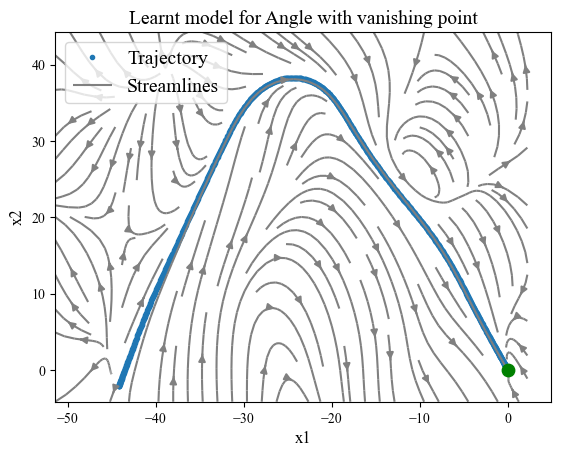

In [15]:
fig_learntmodel_closed_form = plt.figure(2)
plt.title('Learnt model for ' + name_of_dataset + " with vanishing point", fontsize=14)
plt.plot(data_series[0, :], data_series[1, :], '.', linewidth=0.1)
plt.streamplot(X1, X2, u_learnt, v_learnt, density = 1.1, color ='gray')
plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.scatter(0,0, color='green', s=80, zorder=10)
plt.legend(['Trajectory', 'Streamlines'], loc = "upper left" , frameon = True , prop ={'size': 14 } )
fig_learntmodel_closed_form.show()

### Model for vanishing point and contraction

#### Alpha for vanishing point and contraction

In [16]:
@runtime
def alpha_approx_with_constraint_z(x, y, w, b, dim, d, lam, N, mu, constraint_points, L):
    phi_ = capital_phi_z_function(x, w, b, N, d, dim, L)
    mu = mu*np.eye(dim)
    problem = pc.Problem()
    phi_param = pc.Constant('phi_', phi_)
    lam_param = pc.Constant('lam', lam)
    dim_param = pc.Constant('dim',dim)
    d_param = pc.Constant('d', d)
    mu_param = pc.Constant('mu', mu)
    constraint_points_param = pc.Constant('constraint_points', constraint_points)
    y_reshaped = np.array(np.ravel([y[0], y[1]], 'F'))
    y_reshaped_param = pc.Constant('y_reshaped', y_reshaped)
    alpha_var = pc.RealVariable('alpha_var', (d_param*dim_param, 1))
    # Creating constraints
    for i in range(constraint_points_param):
        constraint_index = i*np.int64(np.floor(len(x[0])/constraint_points))
        x_i = x[:, constraint_index]
        gradient = np.zeros(dim)
        jacobi_function = nd.Jacobian(psi_jacobi)
        jacobi_ = jacobi_function(x_i, w, b, d, dim, L)
        jacobi_param = pc.Constant('jacobi', [0, 0], (2, 2))
        for j in range(len(alpha_var)):
            jacobi_param += pc.Constant(jacobi_[:, :, j]) * alpha_var[j]
        gradient = gradient + 0.5 * (jacobi_param + jacobi_param.T)
        problem.add_constraint(gradient << mu_param)
    obj = ((phi_param * alpha_var) - y_reshaped_param).T * ((phi_param * alpha_var) - y_reshaped_param) + lam_param*(alpha_var.T * alpha_var)
    problem.set_objective('min', obj)
    problem.solve(solver='mosek')
    alpha_var = alpha_var.np.reshape((-1,))
    return alpha_var

#### Solve regression problem

In [17]:
alpha_fdm = alpha_approx_with_constraint_z(x_train, y_train, w, b, dim_of_function, num_of_samples, lambda_, num_of_points, mu, num_of_constraint_points, L_)


 Function alpha_approx_with_constraint_z took 63.6103 seconds


#### Function to learn model

In [18]:
def learnt_model_fdm(t, x):
    func = capital_psi_z_function(x, w, b, num_of_samples, dim_of_function, L_).T @ alpha_fdm
    return func

#### Simulate vector field

In [19]:
data_series_fdm = solve_ivp(learnt_model_fdm, timespan, init_condition, t_eval = t_series).y

#### Plot vector field for learnt model

In [20]:
# Base point or starting point for each vector of the vector field
[X1, X2] = np.meshgrid(x1, x2)

u_learnt_fdm = np.zeros(X1.shape)
v_learnt_fdm = np.zeros(X1.shape)

for (i,j), value in np.ndenumerate(X1):
    Y_prime_fdm = learnt_model_fdm(t, np.array([value, X2[i, j]]))
    u_learnt_fdm[i,j] = Y_prime_fdm[0]
    v_learnt_fdm[i,j] = Y_prime_fdm[1]

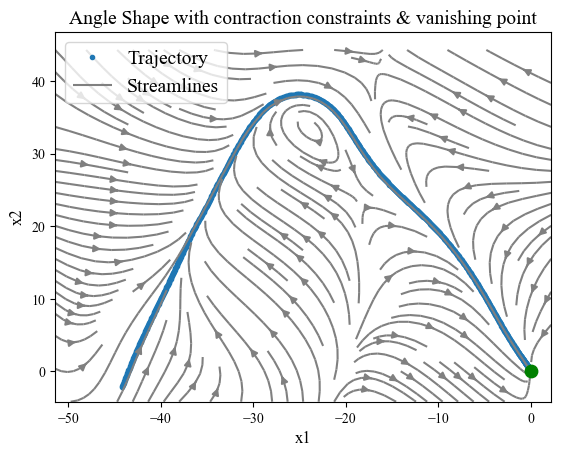

In [21]:
fig_learntmodel_fdm = plt.figure(3)
plt.title(name_of_dataset + " Shape with contraction constraints & vanishing point", fontsize=14)
plt.plot(data_series_fdm[0, :], data_series_fdm[1, :], '.', linewidth=0.1)
plt.streamplot(X1, X2, u_learnt_fdm, v_learnt_fdm, density = 1.1, color ='gray')
plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.scatter(0,0, color='green', s=80, zorder=10)
plt.legend(['Trajectory', 'Streamlines'], loc = "upper left" , frameon = True , prop ={'size': 14 } )
fig_learntmodel_fdm.show()

#### Reproduction Accuracy

The trajectory error:  [1.13557303 0.76199287 0.95342504]
The mean trajectory error (MTE):  0.9503303132477671


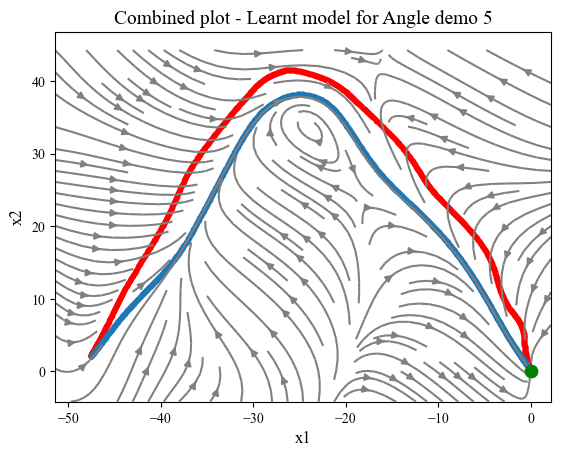

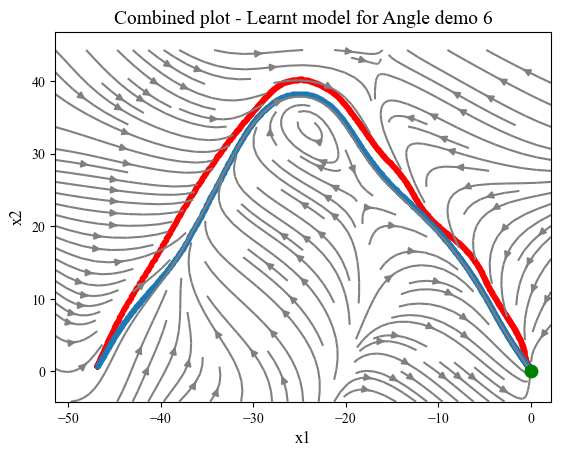

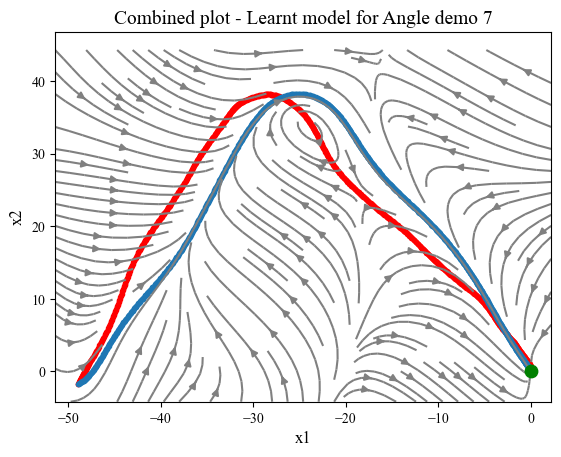

In [22]:
trajectory_error = np.zeros(num_of_test_datasets)

for i in range(num_of_test_datasets):
    demo_pos = num_of_train_datasets + i
    actual_trajectory = dataset['demos'][0, demo_pos][0, 0][0]
    actual_time = dataset['demos'][0, demo_pos][0, 0][1]
    timespan = np.array([actual_time[:, 0], actual_time[:, -1]])
    initial_condition = actual_trajectory[:, 0]
    simulated_trajectory = solve_ivp(learnt_model_fdm, timespan, initial_condition, t_eval = actual_time[0]).y
    error = np.mean(np.linalg.norm(actual_trajectory - simulated_trajectory, ord=2, axis=0) / actual_time[:, -1])
    trajectory_error[i] = error
    demo_number = demo_pos+1
    fig_learntmodel_fdm = plt.figure(i+num_of_train_datasets)
    plt.title('Combined plot - Learnt model for ' + name_of_dataset + ' demo ' + str(demo_number), fontsize=14)
    plt.plot(actual_trajectory[0, :], actual_trajectory[1, :], '.', linewidth=0.1, color = 'r')
    plt.plot(simulated_trajectory[0, :], simulated_trajectory[1, :], '.', linewidth=0.1)
    plt.scatter(0,0, color='green', s=80, zorder=10)
    plt.streamplot(X1, X2, u_learnt_fdm, v_learnt_fdm, density = 1.1, color ='gray')
    plt.xlabel('x1', fontsize=12)
    plt.ylabel('x2', fontsize=12)
    fig_learntmodel_fdm.show()

print('The trajectory error: ', trajectory_error)
print('The mean trajectory error (MTE): ', np.mean(trajectory_error))

#### Save satisfactory feature map parameters

In [23]:
#np.save('RFF_parameters/w_'+name_of_dataset+'_vanish', w)
#np.save('RFF_parameters/b_'+name_of_dataset+'_vanish', b)